In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pint
from uncertainties import ufloat
ureg = pint.UnitRegistry()

Параметры

In [3]:
M = ufloat(28.97, 0.01) * (ureg.g / ureg.mol)
R = 8.314_462_618_153_24 * (ureg.J / ureg.mol / ureg.K)

T = ufloat(26.1 + 273.15, 0.1) * ureg.K
P = ufloat(976.1, 0.1) * ureg.hPa
rho = (P * M) / (R * T)

Re_cr = 1e3
eta_cr = 2e-5 * (ureg.pascal * ureg.second)

ls = 1
d1 = ufloat(3.95, 0.05) * ureg.mm
l1 = ufloat(50, ls) * ureg.cm

d2 = ufloat(3.95, 0.05) * ureg.mm
l2 = ufloat(90, ls) * ureg.cm

d3 = ufloat(5.3, 0.05) * ureg.mm
l3 = ufloat(40, ls) * ureg.cm

$Q_{кр}$

In [4]:
def get_Q_cr(d):
    r = d / 2
    u = (Re_cr * eta_cr) / (r * rho)
    Q_cr = u * np.pi * r ** 2
    return Q_cr.to(ureg.ml / ureg.s)

get_Q_cr(d1)

109.1873949491565+/-1.3831593080645872 <Unit('milliliter / second')>

$\Delta P_{кр}$

In [5]:
def get_dP_cr(d, l):
    Q_cr = get_Q_cr(d)
    r = d / 2
    dP_cr = (Q_cr * 8 * l * eta_cr) / (np.pi * r ** 4)
    return dP_cr.to(ureg.Pa)

get_dP_cr(d3, l3)

60.51985572183906+/-2.2855667158486996 <Unit('pascal')>

$l_{уст}$

In [6]:
0.2 * (d3/2) * Re_cr

530.0+/-5.0 <Unit('millimeter')>

In [7]:
def fit(x_data, y_data, x_err=None, y_err=None, through_zero=False):
    N = len(x_data)

    # TODO не используется
    if x_err is None:
        x_err = np.zeros(N)
    if y_err is None:
        x_err = np.zeros(N)

    if through_zero:
        kn = np.mean(x_data * y_data) / np.mean(x_data**2)
        bn = 0

        ks = np.sqrt(1/(N-1) * (np.mean(y_data**2)/np.mean(x_data**2)-kn**2))
        bs = 0
    else:
        kn = (np.mean (y_data * x_data) - np.mean(y_data) * np.mean(x_data)) / (np.mean(x_data**2) - np.mean(x_data)**2)
        bn = np.mean(y_data) - kn * np.mean(x_data)

        ks = np.sqrt(1/(N-1) * ((np.mean(y_data**2) - np.mean(y_data)**2)/(np.mean(x_data**2) - np.mean(x_data)**2) - kn**2))
        bs = ks * np.sqrt(np.mean(x_data**2)-np.mean(x_data)**2)

    residuals = y_data - (kn * x_data + bn)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y_data - np.mean(y_data))**2)
    r2 = 1 - (ss_res / ss_tot)

    return kn, ks, bn, bs, r2

In [8]:
def graph(d, l, n, through_zero=True):
    # data
    df1 = pd.read_excel('1.3.3.xlsx', sheet_name=f'Лист{2 * n - 1}')
    df2 = pd.read_excel('1.3.3.xlsx', sheet_name=f'Лист{2 * n}')

    x_name = '$\Delta P$, $Па$'
    y_name = '$Q$, $мл/с$'

    # calculations
    r = d / 2
    kn, ks, bn, bs, r2 = fit(df1[x_name], df1[y_name], through_zero=through_zero)
    k = ufloat(kn, ks) * (ureg.ml/ureg.s/ureg.Pa)
    eta = (np.pi * r ** 4) / (8 * l * k)
    Q_cr = max(df1[y_name]) * (ureg.ml / ureg.s)
    u = Q_cr / (np.pi * r ** 2)
    Re = (rho * u * r) / eta

    # plot
    plt.figure(figsize=(8,6), dpi=100) # размер графика
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    # plt.title('Наилучшая прямая для линеаризованной зависимости')
    plt.title(f'$d=({d.n}\pm{d.s}) \ мм$, $l=({l.n}\pm{l.s}) \ см$')
    plt.grid(True, linestyle="dotted") # сетка

    x_max = (max(df2[y_name]) - bn) / kn
    x_line = np.array([0, x_max])  # две точки аппроксимирующей прямой
    y_line = kn * x_line + bn
    k_label = f'$k=({kn:.3f}\pm{ks:.3f}) \ мл/(Па \cdot с)$' + '\n'
    if through_zero:
        b_label = ''
    else:
        b_label = f'$b=({bn:.3f}\pm{bs:.3f}) \ мл/с$' + '\n'
    r2_label = f'$R^2$: ${r2:.10f}$'
    line_label = ''.join([k_label, b_label, r2_label])
    plt.plot(x_line, y_line, label=line_label, alpha=0.7)

    plt.errorbar(df1[x_name], df1[y_name], fmt="xb",  label="Ламинарность", ms=5)

    plt.errorbar(df2[x_name], df2[y_name], fmt="xr",  label="Турбулентность", ms=5)

    plt.legend()
    plt.savefig(f"Q(P){n}" + '.png')

    # log
    print(get_Q_cr(d), "- Критический расход(теоретически)")
    print(get_dP_cr(d, l), "- Критический перепад давлений(теоретически)")
    print(eta.to(ureg.Pa*ureg.s), "- Вязкость воздуха(экспериментально)")
    print(Re.to(ureg.dimensionless), "- Критическое число Рейнольдса(экспериментально)")


109.2+/-1.4 milliliter / second - Критический расход(теоретически)
183+/-8 pascal - Критический перепад давлений(теоретически)
(1.88+/-0.10)e-05 pascal * second - Вязкость воздуха(экспериментально)
(7.6+/-0.5)e+02 dimensionless - Критическое число Рейнольдса(экспериментально)


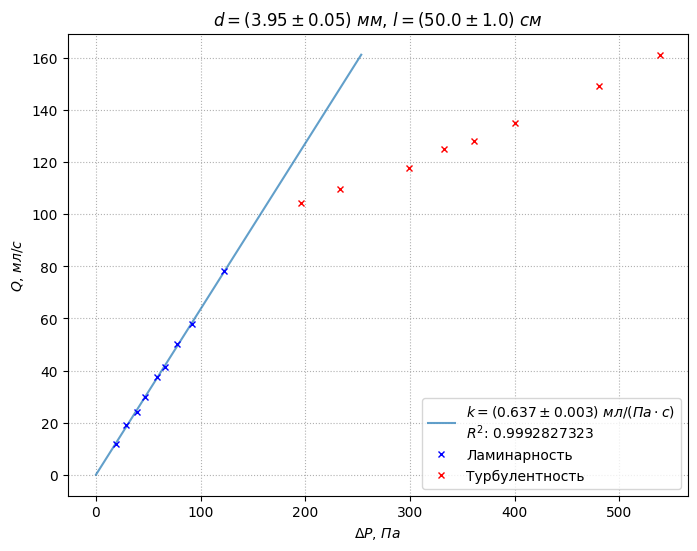

In [9]:
graph(d1, l1, 1)

109.2+/-1.4 milliliter / second - Критический расход(теоретически)
329+/-13 pascal - Критический перепад давлений(теоретически)
(1.98+/-0.10)e-05 pascal * second - Вязкость воздуха(экспериментально)
(5.6+/-0.4)e+02 dimensionless - Критическое число Рейнольдса(экспериментально)


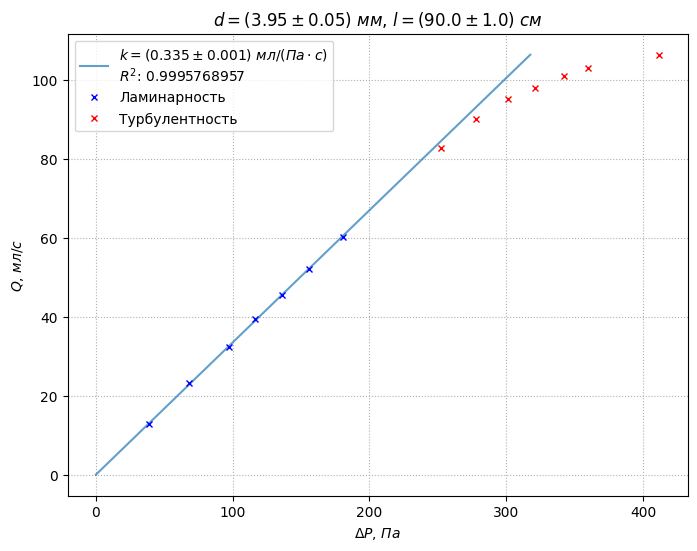

In [10]:
graph(d2, l2, 2)

146.5+/-1.4 milliliter / second - Критический расход(теоретически)
60.5+/-2.3 pascal - Критический перепад давлений(теоретически)
(2.57+/-0.19)e-05 pascal * second - Вязкость воздуха(экспериментально)
(7.6+/-0.6)e+02 dimensionless - Критическое число Рейнольдса(экспериментально)


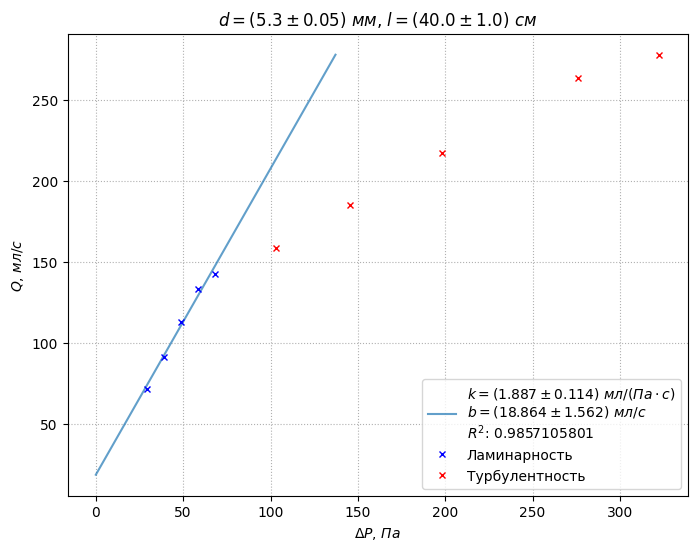

In [11]:
graph(d3, l3, 3, through_zero=False)